### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import os, json, multiprocessing
import torch     
from torch import nn                                
from torch.nn import functional as F

### **LOADING PRETRAINED BERT:**
- The original BERT Model has hundreds of millions of parameters. Here, I have installed two versions of pretrained BERT: BERT Base is the original BERT Model that requires a lot computational resources to fine tune while BERT Small is a small version to facilitate demonstration. 

In [4]:
#@ INSTALLING BERT MODEL: 
d2l.DATA_HUB["bert.base"] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')          # Getting BERT Base Model. 
d2l.DATA_HUB["bert.small"] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')         # Getting BERT Small Model. 

- The pretrained BERT Model contains a vocab json file that defines the vocabulary set and a pretrained params file of the pretrained parameters. I will define a function to load pretrained BERT parameters. 

In [5]:
#@ LOADING PRETRAINED BERT MODEL PARAMETERS: 
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, 
                          num_heads, num_layers, dropout, max_len, devices):             # Loading Pretrained Model. 
  data_dir = d2l.download_extract(pretrained_model)                                      # Downloading and Extracting Model. 
  vocab = d2l.Vocab()                                                                    # Initializing Vocabulary. 
  vocab.idx_to_token = json.load(open(os.path.join(data_dir, "vocab.json")))             # Initializing BERT Vocabulary. 
  vocab.token_to_idx = {token: idx for idx, token in 
                        enumerate(vocab.idx_to_token)}
  bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256], 
                       ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens, 
                       num_heads=4, num_layers=2, dropout=0.2, max_len=max_len, 
                       key_size=256, query_size=256, value_size=256, 
                       hid_in_features=256,mlm_in_features=256,nsp_in_features=256)      # Initializing BERT Model. 
  bert.load_state_dict(torch.load(os.path.join(data_dir, "pretrained.params")))          # Loading Pretrained Model Parameters. 
  return bert, vocab

In [7]:
#@ LOADING PRETRAINED BERT MODEL: 
devices = d2l.try_all_gpus()                                                              # Initialization. 
bert, vocab = load_pretrained_model("bert.small", num_hiddens=256, ffn_num_hiddens=512, 
                                    num_heads=4, num_layers=2, dropout=0.1, max_len=512, 
                                    devices=devices)                                      # Implementation of Function. 

### **DATASET FOR FINE TUNING BERT:**
- I will define a customized dataset where each example consist of premise and hypothesis to form a pair of text sequence and is packed into one BERT input sequence. The segment ids are used to distinguish the premise and the hypothesis in a BERT input sequence. I will define a maximum length of BERT input sequence where the last token of longer input text pair keeps getting removed until maximum length is met. 

In [8]:
#@ DATASET FOR FINE TUNING BERT MODEL: 
class SNLIBERTDataset(torch.utils.data.Dataset):                             # Initializing Dataset Class. 
  def __init__(self, dataset, max_len, vocab=None):                          # Constructor Function. 
    all_premise_hypothesis_tokens = [[p_tokens, h_tokens] for p_tokens, 
                                     h_tokens in zip(*[d2l.tokenize(
                                         [s.lower() for s in sentences])
                                     for sentences in dataset[:2]])]         # Initializing Premise and Hypothesis Tokens. 
    self.labels = torch.tensor(dataset[2])                                   # Initializing Labels. 
    self.vocab = vocab                                                       # Initializing Vocabulary. 
    self.max_len = max_len                                                   # Initializing Maximum Length of Inputs. 
    (self.all_token_ids,self.all_segments,self.valid_lens)=self._preprocess(
        all_premise_hypothesis_tokens)                                       # Initializing Preprocess Function. 
    print("read", str(len(self.all_token_ids)), "examples")                  # Inspecting the Data. 

  def _preprocess(self, all_premise_hypothesis_tokens):                      # Preprocess Function. 
    pool = multiprocessing.Pool(4)                                           # Using 4 Worker Processess. 
    out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)           # Mapping Tokens. 
    all_token_ids = [token_ids for token_ids, segments, valid_len in out]    # Getting Token IDs.
    all_segments = [segments for token_ids, segments, valid_len in out]      # Getting Segments. 
    valid_lens = [valid_len for token_ids, segments, valid_len in out]       # Getting Valid Length. 
    return (torch.tensor(all_token_ids, dtype=torch.long), 
            torch.tensor(all_segments, dtype=torch.long), 
            torch.tensor(valid_lens))
  
  def _mp_worker(self, premise_hypothesis_tokens):
    p_tokens, h_tokens = premise_hypothesis_tokens                           # Initializing Tokens.  
    self._truncate_pair_of_tokens(p_tokens, h_tokens)                        # Initializing Truncating Function. 
    tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)       # Getting Tokens and Segments. 
    token_ids = self.vocab[tokens] + [self.vocab["<pad>"]] * (self.max_len- 
                                                              len(tokens))   # Getting Tokens IDs. 
    segments = segments + [0] * (self.max_len - len(segments))               # Getting Segments. 
    valid_len = len(tokens)                                                  # Number of Tokens. 
    return token_ids, segments, valid_len
  
  def _truncate_pair_of_tokens(self, p_tokens, h_tokens):                    # Truncating Tokens. 
    while len(p_tokens) + len(h_tokens) > self.max_len - 3:                  # Inspecting Length of Tokens. 
      if len(p_tokens) > len(h_tokens):
        p_tokens.pop()                                                       # Removing Last Token. 
      else: 
        h_tokens.pop()                                                       # Removing Last Token. 
  
  def __getitem__(self, idx):
    return (self.all_token_ids[idx], self.all_segments[idx], 
            self.valid_lens[idx]), self.labels[idx]
  
  def __len__(self):
    return len(self.all_token_ids)

In [10]:
#@ GENERATING TRAINING AND TESTING EXAMPLES: 
batch_size, max_len, num_workers = 512, 128, 2                               # Initializing Parameters. 
data_dir = d2l.download_extract("SNLI")                                      # Downloading and Extracting. 
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)   # Getting Training Set. 
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)   # Getting Test Set. 
train_iter = torch.utils.data.DataLoader(train_set, batch_size,shuffle=True, 
                                         num_workers=num_workers)            # Initializing Training Iterations. 
test_iter = torch.utils.data.DataLoader(test_set, batch_size,shuffle=False, 
                                        num_workers=num_workers)             # Initializing Test Iterations. 

read 549367 examples
read 9824 examples


### **FINE TUNING BERT CLASSIFIER MODEL:**
- BERT for natural language inference requires only an extra MLP consisting of two fully connected layers. The MLP transforms the BERT representation of special tokens which encodes the information of both the premise and hypothesis into three outputs of natural language inference: entailment, contradiction and neutral.  

In [11]:
#@ INITIALIZATION OF BERT CLASSIFIER: 
class BERTClassifier(nn.Module):                               # BERT Classifier. 
  def __init__(self, bert):                                    # Constructor Function. 
    super(BERTClassifier, self).__init__()
    self.encoder = bert.encoder                                # Initializing BERT Encoder. 
    self.hidden = bert.hidden                                  # Initializing BERT Hidden Layer. 
    self.output = nn.Linear(256, 3)                            # Initializing Linear Output Layer. 
  
  def forward(self, inputs):                                   # Forward Propagation Function. 
    tokens_X, segments_X, valid_lens_X = inputs                # Initialization. 
    encoded_X = self.encoder(tokens_X, segments_X, 
                             valid_lens_X)                     # Encoding the Inputs. 
    return self.output(self.hidden(encoded_X[:, 0, :]))        # Implementation of Output Layer. 

loss 0.521, train acc 0.790, test acc 0.782
1994.1 examples/sec on [device(type='cuda', index=0)]


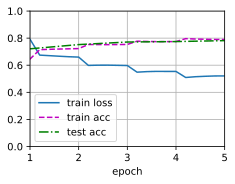

In [12]:
#@ TRAINING AND EVALUATING THE MODEL: 
net = BERTClassifier(bert)                                     # Initializing BERT Classifier. 
lr, num_epochs = 1e-4, 5                                       # Initialization. 
trainer = torch.optim.Adam(net.parameters(), lr=lr)            # Initializing Adam Optimizer. 
loss = nn.CrossEntropyLoss(reduction="none")                   # Initializing Cross Entropy Loss Function. 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, 
               num_epochs, devices)                            # Training and Evaluating Model. 